# 1D Heat equation; PINN

In [750]:
# initial plot
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import pandas as pd
from torch.utils.tensorboard import SummaryWriter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import datetime
from softadapt import LossWeightedSoftAdapt

We will store the temperature u, at a given x,t in a 2D tensor called U(t,x)

In [751]:
# setup time-space geometry
num_points = 51
x_start = 0
x_stop = 1
num_timesteps = 1000
t_start = 0
t_stop = 1 
x = np.linspace(start=x_start, stop=x_stop, num=num_points)
t = np.linspace(start=t_start, stop=t_stop, num=num_timesteps)

## PINN to learn the 1D-heat diffusion equation

The goal of the following section is to show a PINN using:

- Initial condition loss
- Boundary condition loss
- PDE loss
- Data driven loss

In [752]:
#Use GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [753]:
#Allow access to Google drive data when using colab
colab = False
if colab == True:
    from google.colab import drive
    drive.mount('/gdrive')
    %cd /gdrive/My Drive/colab_scratch

In [754]:
U_load = np.load("../../data/1d-heat-U.npy")
print(f"U shape: {U_load.shape}")

U shape: (1000, 51)


In [755]:
#Store x,t in a feature array of 2 columns
features = np.ones((U_load.shape[0]*U_load.shape[1],2))
features[:,1] = np.tile(x,U_load.shape[0])
features[:,0] = np.repeat(t,U_load.shape[1])
print(f"First 5 features {features[0:5]}\n")
print(f"Last 5 features  {features[-5:]}")

First 5 features [[0.   0.  ]
 [0.   0.02]
 [0.   0.04]
 [0.   0.06]
 [0.   0.08]]

Last 5 features  [[1.   0.92]
 [1.   0.94]
 [1.   0.96]
 [1.   0.98]
 [1.   1.  ]]


In [756]:
labels = np.ones((U_load.shape[0]*U_load.shape[1],1))
labels = U_load.ravel()
print(f"First 5 temperature label data: {labels[0:5]}")

First 5 temperature label data: [0.         0.06279052 0.12533323 0.18738131 0.24868989]


In [757]:
#Set datatype expected by PyTorch
labels = labels.astype(np.float32)
features = features.astype(np.float32)

Data now needs pre-processing ready for PyTorch training including:

- Feature scaling
- Train-test splitting for model validation

In [758]:
### Pre-processing stage
std_scaler = StandardScaler()
scaler_features = std_scaler.fit(features)
scaled_features = scaler_features.transform(features)

print(f"\nPre-scaling:\n {features[0:5]}")
print(f"Mean: {features.mean()} Std: {features.std()}")
print(f"\nPost-scaling:\n {scaled_features[0:5]}")
print(f"Mean: {scaled_features.mean()} Std: {scaled_features.std()}")


Pre-scaling:
 [[0.   0.  ]
 [0.   0.02]
 [0.   0.04]
 [0.   0.06]
 [0.   0.08]]
Mean: 0.5000000596046448 Std: 0.2916906177997589

Post-scaling:
 [[-1.7303196 -1.6984155]
 [-1.7303196 -1.6304789]
 [-1.7303196 -1.5625423]
 [-1.7303196 -1.4946057]
 [-1.7303196 -1.426669 ]]
Mean: 2.1541818995274298e-08 Std: 1.0


In [759]:
# Get feature data for initial condition, boundary condition and interior points
features_init = scaled_features[0:51]

features_x0 = scaled_features[0::51]
features_xstop = scaled_features[50::51]
features_bound = np.append(features_x0, features_xstop, axis=0)

features_interior = np.empty((0,1))
start=1
block_size=49
skip=2
while start < features.shape[0]:
    features_interior = np.append(features_interior, scaled_features[start:start+block_size])
    start = start + block_size + skip

length = features_interior.ravel().shape[0]
features_interior = features_interior.reshape((int(length/2),2))

#Now split them into x and t as this is more generic for future multi-dimensional 
t_init = features_init[:, 0]
t_bound = features_bound[:, 0]
t_interior = features_interior[:, 0]
x_init = features_init[:, 1]
x_bound = features_bound[:, 1]
x_interior = features_interior[:, 1]

print(f"Time vals init condition shape: {t_init.shape}")
print(f"Time vals boundary condition shape: {t_bound.shape}")
print(f"Time vals interior condition shape: {t_interior.shape}")
print(f"Space vals init condition shape: {x_init.shape}")
print(f"Space vals boundary condition shape: {x_bound.shape}")
print(f"Space vals interior shape: {x_interior.shape}")

Time vals init condition shape: (51,)
Time vals boundary condition shape: (2000,)
Time vals interior condition shape: (49000,)
Space vals init condition shape: (51,)
Space vals boundary condition shape: (2000,)
Space vals interior shape: (49000,)


In [760]:
# Get label data for initial condition, boundary condition and interior points
labels_init = labels[0:51]

labels_x0 = labels[0::51]
labels_xstop = labels[50::51]
labels_bound = np.append(labels_x0, labels_xstop, axis=0)

labels_interior = np.empty((0,1))
start=1
block_size=49
skip=2
while start < labels.shape[0]:
    labels_interior = np.append(labels_interior, labels[start:start+block_size])
    start = start + block_size + skip

print(f"Labels for init condition shape: {labels_init.shape}")
print(f"Labels for left boundary condition shape: {labels_x0.shape}")
print(f"Labels for right boundary condition shape: {labels_xstop.shape}")
print(f"\tLabels for both boundary condition shape: {labels_bound.shape}")
print(f"Labels for interior shape: {labels_interior.shape}")

Labels for init condition shape: (51,)
Labels for left boundary condition shape: (1000,)
Labels for right boundary condition shape: (1000,)
	Labels for both boundary condition shape: (2000,)
Labels for interior shape: (49000,)


In [761]:
#Train test splitting
test_size = 0.2

#Interior data
(
    x_interior_train,
    x_interior_test,
    t_interior_train,
    t_interior_test,
    labels_interior_train,
    labels_interior_test,
) = train_test_split(x_interior, t_interior, labels_interior, test_size=test_size)

#Initial condition data
(
    x_init_train,
    x_init_test,
    t_init_train,
    t_init_test,
    labels_init_train,
    labels_init_test,
) = train_test_split(x_init, t_init, labels_init, test_size=test_size)

#Boundary condition data
(
    x_bound_train,
    x_bound_test,
    t_bound_train,
    t_bound_test,
    labels_bound_train,
    labels_bound_test,
) = train_test_split(x_bound, t_bound, labels_bound, test_size=test_size)

print(f"x_interior_train shape({x_interior_train.shape}) type({type(x_interior_train)})")
print(f"x_interior_test shape({x_interior_test.shape}) type({type(x_interior_test)})")
print(f"t_interior_train shape({t_interior_train.shape}) type({type(t_interior_train)})")
print(f"t_interior_test shape({t_interior_test.shape}) type({type(t_interior_test)})")
print(f"labels_interior_train shape({labels_interior_train.shape}) type({type(labels_interior_train)})")
print(f"labels_interior_test shape({labels_interior_test.shape}) type({type(labels_interior_test)})")

print()
print(f"x_bound_train shape({x_bound_train.shape}) type({type(x_bound_train)})")
print(f"x_bound_test shape({x_bound_test.shape}) type({type(x_bound_test)})")
print(f"t_bound_train shape({t_bound_train.shape}) type({type(t_bound_train)})")
print(f"t_bound_test shape({t_bound_test.shape}) type({type(t_bound_test)})")
print(f"labels_bound_train shape({labels_bound_train.shape}) type({type(labels_bound_train)})")
print(f"labels_bound_test shape({labels_bound_test.shape}) type({type(labels_bound_test)})")

print()
print(f"x_init_train shape({x_init_train.shape}) type({type(x_init_train)})")
print(f"x_init_test shape({x_init_test.shape}) type({type(x_init_test)})")
print(f"t_init_train shape({t_init_train.shape}) type({type(t_init_train)})")
print(f"t_init_test shape({t_init_test.shape}) type({type(t_init_test)})")
print(f"labels_init_train shape({labels_init_train.shape}) type({type(labels_init_train)})")
print(f"labels_init_test shape({labels_init_test.shape}) type({type(labels_init_test)})")

x_interior_train shape((39200,)) type(<class 'numpy.ndarray'>)
x_interior_test shape((9800,)) type(<class 'numpy.ndarray'>)
t_interior_train shape((39200,)) type(<class 'numpy.ndarray'>)
t_interior_test shape((9800,)) type(<class 'numpy.ndarray'>)
labels_interior_train shape((39200,)) type(<class 'numpy.ndarray'>)
labels_interior_test shape((9800,)) type(<class 'numpy.ndarray'>)

x_bound_train shape((1600,)) type(<class 'numpy.ndarray'>)
x_bound_test shape((400,)) type(<class 'numpy.ndarray'>)
t_bound_train shape((1600,)) type(<class 'numpy.ndarray'>)
t_bound_test shape((400,)) type(<class 'numpy.ndarray'>)
labels_bound_train shape((1600,)) type(<class 'numpy.ndarray'>)
labels_bound_test shape((400,)) type(<class 'numpy.ndarray'>)

x_init_train shape((40,)) type(<class 'numpy.ndarray'>)
x_init_test shape((11,)) type(<class 'numpy.ndarray'>)
t_init_train shape((40,)) type(<class 'numpy.ndarray'>)
t_init_test shape((11,)) type(<class 'numpy.ndarray'>)
labels_init_train shape((40,)) type(

In [762]:
features_interior[:, 0]

array([-1.73031962, -1.73031962, -1.73031962, ...,  1.73031962,
        1.73031962,  1.73031962])

In [763]:
U_load.shape

(1000, 51)

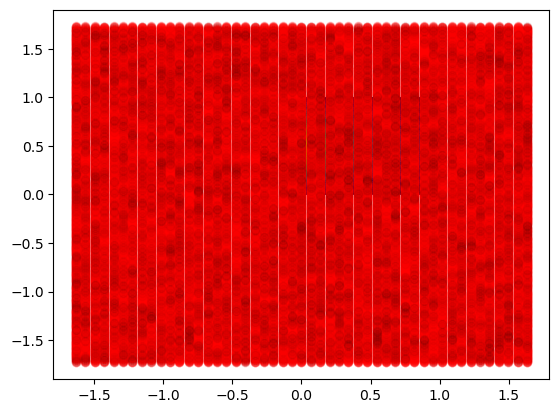

In [764]:
#Lets QC these training and testing locations
f,ax = plt.subplots()
ax.pcolormesh(features[:,0].reshape((1000,51)), features[:,1].reshape((1000,51)), labels.reshape((1000,51)), shading='gouraud',alpha=0.1)
ax.scatter(x_interior_train,t_interior_train,alpha=0.2,c="Red")
ax.scatter(x_interior_test,t_interior_test,alpha=0.01,c="Black")
ax.scatter(x_interior_test,t_interior_test,alpha=0.01,c="Black")
plt.show()

In [765]:
# Define MLP model architecture class
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        """_summary_
        """
        super().__init__()
        self.linear_stack = torch.nn.Sequential(
            torch.nn.Linear(2, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 1)
        )

        # torch.nn.init.xavier_uniform_(self.linear_stack.weight)

    def forward(self, x, t):
        """_summary_

        Args:
            x (_type_): _description_
            t (_type_): _description_

        Returns:
            _type_: _description_
        """
        inputs = torch.cat([x,t], axis=1).to(device)
        return self.linear_stack(inputs)

In [766]:
def train_loop(x_bound, x_init, x_interior, t_bound, t_init, t_interior,labels_bound, labels_init, labels_interior, boundary_loss_weights,pde_loss_weights,init_loss_weights, model, loss_fn, optimizer, writer=None):
    """_summary_

    Args:
        x_bound (_type_): _description_
        x_init (_type_): _description_
        x_interior (_type_): _description_
        t_bound (_type_): _description_
        t_init (_type_): _description_
        t_interior (_type_): _description_
        labels_bound (_type_): _description_
        labels_init (_type_): _description_
        labels_interior (_type_): _description_
        model (_type_): _description_
        loss_fn (_type_): _description_
        optimizer (_type_): _description_
    """
    optimizer.zero_grad()

    interior_pred = model(x_interior, t_interior)
    bound_pred = model(x_bound, t_bound)
    init_pred = model(x_init, t_init)
    
    boundary_loss, initial_loss, pde_loss, data_loss = \
        loss_fn(
            interior_pred, bound_pred, init_pred, 
            labels_interior, labels_bound, labels_init, 
            x_interior, t_interior)
    
    print(f"\tBefore adaption: Initial condition loss: {initial_loss}")
    print(f"\tBefore adaption: Boundary condition loss: {boundary_loss}")
    print(f"\tBefore adaption: PDE loss: {pde_loss}")
    print(f"\tBefore adaption: Data loss: {data_loss}")

    #Calculate dBoundaryLoss/dTheta
    boundary_loss.backward(retain_graph=True)
    bound_grads = []
    for name, param in model.named_parameters():
        if "weight" in name:
            bound_grads.append(param.grad.view(-1))
    
    bound_grads = torch.cat(bound_grads)
    optimizer.zero_grad()
    
    #Calculate dInitialLoss/dTheta
    initial_loss.backward(retain_graph=True)
    init_grads = []
    for name, param in model.named_parameters():
        if "weight" in name:
            init_grads.append(param.grad.view(-1))
    
    init_grads = torch.cat(init_grads)
    optimizer.zero_grad()

    #Calculate dInitialLoss/dTheta
    pde_loss.backward(retain_graph=True)
    pde_grads = []
    for name, param in model.named_parameters():
        if "weight" in name:
            pde_grads.append(param.grad.view(-1))
    
    pde_grads = torch.cat(pde_grads)
    optimizer.zero_grad()

    #Calculate dDataLoss/dTheta
    data_loss.backward(retain_graph=True)
    data_grads = []
    for name, param in model.named_parameters():
        if "weight" in name:
            data_grads.append(param.grad.view(-1))    
    
    data_grads = torch.cat(data_grads)
    optimizer.zero_grad()

    #Compute adaptive weight for each component of total loss
    #relative to the mean gradient of data_loss w.r.t layer weights
    boundary_loss_lambda_hat = torch.max(torch.abs(data_grads)) / torch.mean(torch.abs(bound_grads))
    init_loss_lambda_hat = torch.max(torch.abs(data_grads)) / torch.mean(torch.abs(init_grads))
    pde_loss_lambda_hat = torch.max(torch.abs(data_grads)) / torch.mean(torch.abs(pde_grads))
    
    alpha = 0.1
    if epoch == 0:
        boundary_loss_weights.append((alpha * boundary_loss_lambda_hat)) 
        init_loss_weights.append((alpha * init_loss_lambda_hat))
        pde_loss_weights.append((alpha * pde_loss_lambda_hat))
    else:
        boundary_loss_weights.append((alpha * boundary_loss_lambda_hat) + ((1 - alpha)*boundary_loss_weights[epoch-1]))
        init_loss_weights.append((alpha * init_loss_lambda_hat) + ((1 - alpha)*init_loss_weights[epoch-1]))
        pde_loss_weights.append((alpha * pde_loss_lambda_hat) + ((1 - alpha)*pde_loss_weights[epoch-1]))

    # boundary_loss_weight = 1
    # init_loss_weight = 1
    # pde_loss_weight = 1
    # data_loss_weight = 1

    #Create total loss to update all network parameters
    total_loss = \
        data_loss + \
        (init_loss_weights[epoch] * initial_loss) + \
        (pde_loss_weights[epoch] * pde_loss) + \
        (boundary_loss_weights[epoch] * boundary_loss)
    
    print(f"\t\tAfter adaption: Initial condition loss: {initial_loss * init_loss_weights[epoch]}")
    print(f"\t\tAfter adaption: Boundary condition loss: {boundary_loss * boundary_loss_weights[epoch]}")
    print(f"\t\tAfter adaption: PDE loss: {pde_loss * pde_loss_weights[epoch]}")
    print(f"\t\tAfter adaption: Data loss: {data_loss}")

    if writer:
        writer.add_scalar('training_boundary_loss',boundary_loss,epoch)
        writer.add_scalar('training_init_loss',initial_loss,epoch)
        writer.add_scalar('training_pde_loss',pde_loss,epoch)
        writer.add_scalar('training_data_loss',data_loss,epoch)
        writer.add_scalar('training_weighted_boundary_loss',boundary_loss * boundary_loss_weights[epoch],epoch)
        writer.add_scalar('training_weighted_init_loss',initial_loss * init_loss_weights[epoch],epoch)
        writer.add_scalar('training_weighted_pde_loss',pde_loss * pde_loss_weights[epoch],epoch)
        writer.add_scalar('training_boundary_loss_weight',boundary_loss_weights[epoch],epoch)
        writer.add_scalar('training_init_loss_weight',init_loss_weights[epoch],epoch)
        writer.add_scalar('training_pde_loss_weight',pde_loss_weights[epoch],epoch)
    
    total_loss.backward()
    optimizer.step()

In [767]:
def train_loop_softadapt(x_bound, x_init, x_interior, t_bound, t_init, t_interior,labels_bound, labels_init, labels_interior, boundary_losses,pde_losses,init_losses,data_losses,adapt_weights, model, loss_fn, optimizer, writer=None):
    optimizer.zero_grad()

    interior_pred = model(x_interior, t_interior)
    bound_pred = model(x_bound, t_bound)
    init_pred = model(x_init, t_init)
    
    boundary_loss, initial_loss, pde_loss, data_loss = \
        loss_fn(
            interior_pred, bound_pred, init_pred, 
            labels_interior, labels_bound, labels_init, 
            x_interior, t_interior)
    
    print(f"\tBefore adaption: Initial condition loss: {initial_loss}")
    print(f"\tBefore adaption: Boundary condition loss: {boundary_loss}")
    print(f"\tBefore adaption: PDE loss: {pde_loss}")
    print(f"\tBefore adaption: Data loss: {data_loss}")

    loss_weighted_softadapt_object  = LossWeightedSoftAdapt(beta=0.1)
    
    print(boundary_loss)
    
    boundary_losses.append(boundary_loss)
    pde_losses.append(pde_loss)
    data_losses.append(data_loss)
    init_losses.append(initial_loss)
        
    if epoch >= 5:
        adapt_weights = loss_weighted_softadapt_object.get_component_weights(
            torch.tensor(boundary_losses[epoch-5:epoch]),
            torch.tensor(init_losses[epoch-5:epoch]),
            torch.tensor(pde_losses[epoch-5:epoch]),
            torch.tensor(data_losses[epoch-5:epoch]))

        #Create total loss to update all network parameters
    total_loss = \
        adapt_weights[0]*boundary_loss + \
        adapt_weights[1]*initial_loss + \
        adapt_weights[2]*pde_loss + \
        adapt_weights[3]*data_loss
    
    print(boundary_loss)

    print(f"\t\tAdapt weights (bound,init,pde,data): {adapt_weights}")
    print(f"\t\tAfter adaption: Initial condition loss: {adapt_weights[1]*initial_loss}")
    print(f"\t\tAfter adaption: Boundary condition loss: {adapt_weights[0]*boundary_loss}")
    print(f"\t\tAfter adaption: PDE loss: {adapt_weights[2]*pde_loss}")
    print(f"\t\tAfter adaption: Data loss: {adapt_weights[3]*data_loss}")

    if writer:
        writer.add_scalar('training_boundary_loss',boundary_loss,epoch)
        writer.add_scalar('training_init_loss',initial_loss,epoch)
        writer.add_scalar('training_pde_loss',pde_loss,epoch)
        writer.add_scalar('training_data_loss',data_loss,epoch)
        writer.add_scalar('training_boundary_loss_weight',adapt_weights[0],epoch)
        writer.add_scalar('training_init_loss_weight',adapt_weights[1],epoch)
        writer.add_scalar('training_pde_loss_weight',adapt_weights[2],epoch)
        writer.add_scalar('training_data_loss_weight',adapt_weights[3],epoch)

    total_loss.backward()
    optimizer.step()
    

In [768]:
def train_loop_softadapt_man(x_bound, x_init, x_interior, t_bound, t_init, t_interior,labels_bound, labels_init, labels_interior, boundary_losses,pde_losses,init_losses,data_losses, model, loss_fn, optimizer, writer=None):
    optimizer.zero_grad()

    interior_pred = model(x_interior, t_interior)
    bound_pred = model(x_bound, t_bound)
    init_pred = model(x_init, t_init)
    
    boundary_loss, initial_loss, pde_loss, data_loss = \
        loss_fn(
            interior_pred, bound_pred, init_pred, 
            labels_interior, labels_bound, labels_init, 
            x_interior, t_interior)
    
    print(f"\tBefore adaption: Initial condition loss: {initial_loss}")
    print(f"\tBefore adaption: Boundary condition loss: {boundary_loss}")
    print(f"\tBefore adaption: PDE loss: {pde_loss}")
    print(f"\tBefore adaption: Data loss: {data_loss}")

    #Append loss to list of previous losses
    boundary_losses.append(boundary_loss)
    pde_losses.append(pde_loss)
    data_losses.append(data_loss)
    init_losses.append(initial_loss)

    #Compute weight
    if epoch != 0:
        adapt_weights = torch.nn.functional.softmax(torch.tensor([boundary_loss,initial_loss,pde_loss,data_loss]))
    else:
        adapt_weights = torch.tensor([1,1,1,1])

        #Create total loss to update all network parameters
    total_loss = \
        adapt_weights[0]*boundary_loss + \
        adapt_weights[1]*initial_loss + \
        adapt_weights[2]*pde_loss + \
        adapt_weights[3]*data_loss

    print(f"\t\tAdapt weights (bound,init,pde,data): {adapt_weights}")
    print(f"\t\tAfter adaption: Initial condition loss: {adapt_weights[1]*initial_loss}")
    print(f"\t\tAfter adaption: Boundary condition loss: {adapt_weights[0]*boundary_loss}")
    print(f"\t\tAfter adaption: PDE loss: {adapt_weights[2]*pde_loss}")
    print(f"\t\tAfter adaption: Data loss: {adapt_weights[3]*data_loss}")

    if writer:
        writer.add_scalar('training_boundary_loss',boundary_loss,epoch)
        writer.add_scalar('training_init_loss',initial_loss,epoch)
        writer.add_scalar('training_pde_loss',pde_loss,epoch)
        writer.add_scalar('training_data_loss',data_loss,epoch)
        writer.add_scalar('training_boundary_loss_weight',adapt_weights[0],epoch)
        writer.add_scalar('training_init_loss_weight',adapt_weights[1],epoch)
        writer.add_scalar('training_pde_loss_weight',adapt_weights[2],epoch)
        writer.add_scalar('training_data_loss_weight',adapt_weights[3],epoch)

    total_loss.backward()
    optimizer.step()
    

In [769]:
def combined_physics_data_loss(interior_pred, bound_pred, init_pred, interior_labels, bound_labels, init_labels, x_interior, t_interior):
    """_summary_

    Args:
        interior_pred (_type_): _description_
        bound_pred (_type_): _description_
        init_pred (_type_): _description_
        interior_labels (_type_): _description_
        bound_labels (_type_): _description_
        init_labels (_type_): _description_
        x_interior (_type_): _description_
        t_interior (_type_): _description_

    Returns:
        _type_: _description_
    """
    dudx = torch.autograd.grad(interior_pred.sum(), x_interior, retain_graph=True, create_graph=True)[0]
    dudt = torch.autograd.grad(interior_pred.sum(), t_interior, retain_graph=True, create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt.sum(), t_interior, retain_graph=True, create_graph=True)[0]
    pde_values = (dudx * d2udt2) - dudt

    mse = torch.nn.MSELoss()
    pde_zeros = torch.zeros_like(pde_values)
    pde_loss = mse(pde_zeros,pde_values)

    initial_loss = mse(init_labels, init_pred)
    boundary_loss = mse(bound_labels, bound_pred)
    data_loss = mse(interior_pred, interior_labels)
    
    return boundary_loss, initial_loss, pde_loss, data_loss

In [770]:
def test_loop(x_bound, x_init, x_interior, t_bound, t_init, t_interior,labels_bound, labels_init, labels_interior, model, loss_fn, writer=None):
    
    interior_pred = model(x_interior, t_interior)
    bound_pred = model(x_bound, t_bound)
    init_pred = model(x_init, t_init)

    boundary_loss, initial_loss, pde_loss, data_loss = \
        loss_fn(
            interior_pred, bound_pred, init_pred, 
            labels_interior, labels_bound, labels_init, 
            x_interior, t_interior)
    
    if writer:
        writer.add_scalar('testing_boundary_loss',boundary_loss,epoch)
        writer.add_scalar('testing_init_loss',initial_loss,epoch)
        writer.add_scalar('testing_pde_loss',pde_loss,epoch)
        writer.add_scalar('testing_data_loss',data_loss,epoch)
    
    print(f"\n\tTesting: Initial condition loss: {initial_loss}")
    print(f"\tTesting: Boundary condition loss: {boundary_loss}")
    print(f"\tTesting: PDE loss: {pde_loss}")
    print(f"\tTesting: Data loss: {data_loss}")

In [771]:
x_interior_train.shape

(39200,)

In [772]:
def init_weights(model):
    if isinstance(model, torch.nn.Linear):
        print("Xavier init on linear layer")
        torch.nn.init.xavier_uniform(model.weight)
        model.bias.data.fill_(0.01)

In [773]:
#PINN Model setup
model = NeuralNetwork()
model.to(device)
model.apply(init_weights)
loss_fn = combined_physics_data_loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#Place reshaped input tensors with correct data-type and with calculation of derivatives enabled on available device
x_interior_train=torch.from_numpy(x_interior_train.reshape(x_interior_train.shape[0],1)).float().requires_grad_().to(device)
t_interior_train=torch.from_numpy(t_interior_train.reshape(t_interior_train.shape[0],1)).float().requires_grad_().to(device)
x_init_train=torch.from_numpy(x_init_train.reshape(x_init_train.shape[0],1)).float().requires_grad_().to(device)
t_init_train=torch.from_numpy(t_init_train.reshape(t_init_train.shape[0],1)).float().requires_grad_().to(device)
x_bound_train=torch.from_numpy(x_bound_train.reshape(x_bound_train.shape[0],1)).float().requires_grad_().to(device)
t_bound_train=torch.from_numpy(t_bound_train.reshape(t_bound_train.shape[0],1)).float().requires_grad_().to(device)
labels_bound_train=torch.from_numpy(labels_bound_train.reshape(labels_bound_train.shape[0],1)).float().requires_grad_().to(device)
labels_init_train=torch.from_numpy(labels_init_train.reshape(labels_init_train.shape[0],1)).float().requires_grad_().to(device)
labels_interior_train=torch.from_numpy(labels_interior_train.reshape(labels_interior_train.shape[0],1)).float().requires_grad_().to(device)

x_interior_test=torch.from_numpy(x_interior_test.reshape(x_interior_test.shape[0],1)).float().requires_grad_().to(device)
t_interior_test=torch.from_numpy(t_interior_test.reshape(t_interior_test.shape[0],1)).float().requires_grad_().to(device)
x_init_test=torch.from_numpy(x_init_test.reshape(x_init_test.shape[0],1)).float().requires_grad_().to(device)
t_init_test=torch.from_numpy(t_init_test.reshape(t_init_test.shape[0],1)).float().requires_grad_().to(device)
x_bound_test=torch.from_numpy(x_bound_test.reshape(x_bound_test.shape[0],1)).float().requires_grad_().to(device)
t_bound_test=torch.from_numpy(t_bound_test.reshape(t_bound_test.shape[0],1)).float().requires_grad_().to(device)
labels_bound_test=torch.from_numpy(labels_bound_test.reshape(labels_bound_test.shape[0],1)).float().requires_grad_().to(device)
labels_init_test=torch.from_numpy(labels_init_test.reshape(labels_init_test.shape[0],1)).float().requires_grad_().to(device)
labels_interior_test=torch.from_numpy(labels_interior_test.reshape(labels_interior_test.shape[0],1)).float().requires_grad_().to(device)

#Setup Tensorboard for QCs
tensorboard_dir_name = "weighting"
writer = SummaryWriter("softadapt-man/" + tensorboard_dir_name)

epochs = 1000
boundary_losses = []
pde_losses = []
init_losses = []
data_losses = []
adapt_weights = torch.tensor([1,1,1,1])

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}\n-------------------------------")

    train_loop_softadapt(
        x_bound_train, x_init_train, x_interior_train,
        t_bound_train, t_init_train, t_interior_train,
        labels_bound_train, labels_init_train, labels_interior_train,
        boundary_losses, pde_losses, init_losses, data_losses, adapt_weights,
        model, loss_fn, optimizer, writer)
    
    test_loop(
        x_bound_test, x_init_test, x_interior_test,\
        t_bound_test, t_init_test, t_interior_test,\
        labels_bound_test, labels_init_test, labels_interior_test,\
        model, loss_fn, writer)

print("\nTraining complete!\n")


Xavier init on linear layer
Xavier init on linear layer
Xavier init on linear layer
Xavier init on linear layer
Xavier init on linear layer

Epoch 1
-------------------------------


/var/folders/cl/wp9kmsjx5ln9dxmrjh4hw3740000gn/T/ipykernel_15692/199353368.py:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(model.weight)


	Before adaption: Initial condition loss: 0.3029494881629944
	Before adaption: Boundary condition loss: 0.030323904007673264
	Before adaption: PDE loss: 0.0069586788304150105
	Before adaption: Data loss: 0.07648434489965439
tensor(0.0303, grad_fn=<MseLossBackward0>)
tensor(0.0303, grad_fn=<MseLossBackward0>)
		Adapt weights (bound,init,pde,data): tensor([1, 1, 1, 1])
		After adaption: Initial condition loss: 0.3029494881629944
		After adaption: Boundary condition loss: 0.030323904007673264
		After adaption: PDE loss: 0.0069586788304150105
		After adaption: Data loss: 0.07648434489965439

	Testing: Initial condition loss: 0.1593063920736313
	Testing: Boundary condition loss: 0.03659781068563461
	Testing: PDE loss: 0.00963111687451601
	Testing: Data loss: 0.05947760120034218

Epoch 2
-------------------------------
	Before adaption: Initial condition loss: 0.2257899045944214
	Before adaption: Boundary condition loss: 0.03602265194058418
	Before adaption: PDE loss: 0.009508928284049034
	B

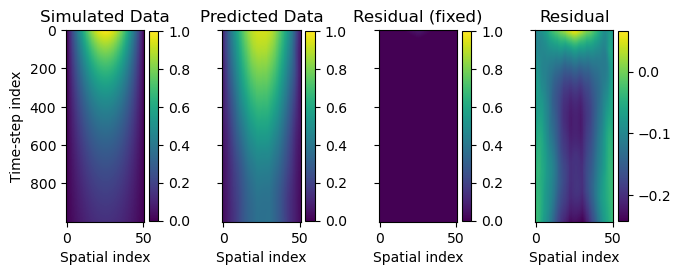

In [774]:
def result_plot(simulation, prediction, savefig=False):
    """_summary_

    Args:
        simulation (_type_): _description_
        prediction (_type_): _description_
    """
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
    f.tight_layout()

    # Min and max of real data so plots share limits
    sim_min = np.min(simulation)
    sim_max = np.max(simulation)
    
    sim_im = ax1.imshow(simulation, aspect=0.125, vmin=sim_min, vmax=sim_max)
    pred_im = ax2.imshow(prediction, aspect=0.125, vmin=sim_min, vmax=sim_max)
    res_im_fixed = ax3.imshow(simulation-np.asarray(prediction), aspect=0.125, vmin=sim_min, vmax=sim_max)
    res_im = ax4.imshow(simulation-np.asarray(prediction), aspect=0.125)

    # Colorbars
    f.colorbar(sim_im, orientation='vertical', shrink=0.45)
    f.colorbar(pred_im, orientation='vertical', shrink=0.45)
    f.colorbar(res_im_fixed, orientation='vertical', shrink=0.45)  
    f.colorbar(res_im, orientation='vertical', shrink=0.45)  
    
    #Titles and labels
    ax1.set_title("Simulated Data")
    ax1.set_ylabel("Time-step index")
    ax1.set_xlabel("Spatial index")
    ax2.set_title("Predicted Data")
    ax2.set_xlabel("Spatial index")
    ax3.set_title("Residual (fixed)")
    ax3.set_xlabel("Spatial index")
    ax4.set_title("Residual")
    ax4.set_xlabel("Spatial index")
    
    # Make spacing suitable
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.6, hspace=None)
    if savefig:
        f.savefig("output_img.png")

# Model inferencing and QC
x = torch.from_numpy(scaled_features[:, 1]).to(device)
t = torch.from_numpy(scaled_features[:, 0]).to(device)


with torch.inference_mode():
    prediction = model(torch.Tensor(x).reshape((x.shape[0],1)),
                       torch.Tensor(t).reshape((t.shape[0],1)))

prediction = prediction.reshape_as(torch.Tensor(U_load))
prediction = prediction.cpu().detach().numpy()
simulation = U_load

result_plot(simulation,prediction)

In [775]:
#Save the model for future use
output_model_path = f"../../models/1d-heat-pinn-{epochs}epochs-lr0.001-adam-x51-t1000-alpha1.22e-3.pt"
torch.save(model.to("cpu"), output_model_path)